Začnimo z uvozom podatkov.

In [120]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from statistics import mean


igralci = pd.DataFrame(pd.read_csv("obdelani_podatki/igralci.csv"))
partije = pd.DataFrame(pd.read_csv("obdelani_podatki/partije.csv"))

partije["rating_beli"] = partije["rating_beli"].apply(lambda x : int(x))
partije["rating_crni"] = partije["rating_crni"].apply(lambda x : int(x))


Najprej si oglejmo razporeditev šahistov po državah. Če poznamo zgodovinsko ozdaje šaha, nas rezultati ne presenečajo.

<AxesSubplot:ylabel='drzava'>

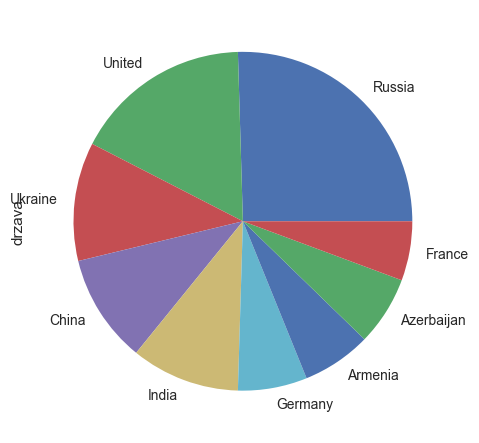

In [121]:
igralci['drzava'].value_counts().head(9).plot.pie(x = 'drzava')

Med prvimi 175 igralci na svetu najdemo le enega slovenca. Tudi če najdemo samo enega, je to glede na velikost naše države v primerjavi s populacjio celega sveta kar presenetljivo!

,ime,rating,mesto,drzava,age,total_games,winrate_win,winrate_draw,winrate_loss
141,Luka Lenic,2633,141,Slovenia,35.0,1346.0,37.0,48.0,15.0


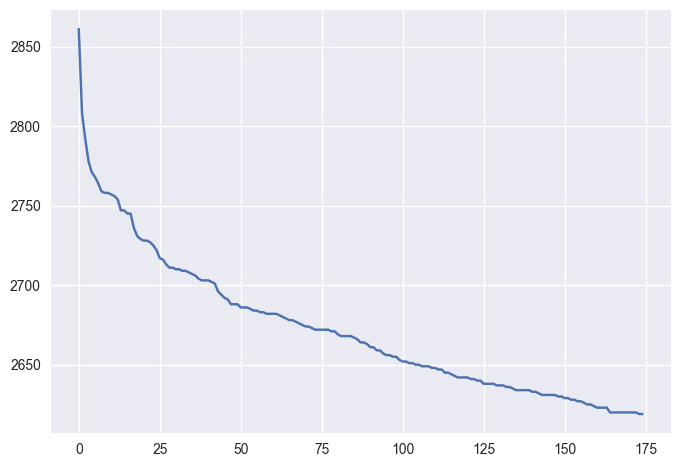

In [122]:
igralci['rating'].plot()
igralci[igralci["drzava"] == "Slovenia"]

Za vsakega izmed igralcev si oglejmo povprečno število potez, ki jih igralec naredi v partiji. 
Za bolj reprezentativne rezultate se omejimo na igralce, za katere imamo zbranih vsaj 60 partij (vmes se prikradejo tudi igralci z 60 ali manj zabeleženimi partijami).

In [123]:
poteze_z_belimi = pd.DataFrame(partije.groupby(['ime_beli'])['st_potez'].sum())
poteze_s_crnimi = pd.DataFrame(partije.groupby(['ime_crni'])['st_potez'].sum())

poteze_z_belimi = poteze_z_belimi.reindex(index=igralci['ime'])
poteze_z_belimi = poteze_z_belimi.reset_index()

poteze_s_crnimi = poteze_s_crnimi.reindex(index=igralci['ime'])
poteze_s_crnimi = poteze_s_crnimi.reset_index()

poteze_sum = pd.concat([poteze_s_crnimi, poteze_z_belimi]).groupby('ime').sum().reset_index()

def st_pobranih_partij(ime):
    return len(partije[partije["ime_beli"] == ime]) + len(partije[partije["ime_crni"] == ime])

poteze_sum["st_pobranih_partij"] = (poteze_sum["ime"].apply(lambda x : st_pobranih_partij(str(x))))
poteze_sum["st_potez"] = round(poteze_sum["st_potez"] / (poteze_sum["ime"].apply(lambda x : st_pobranih_partij(str(x)))))

poteze_sum.sort_values(["st_potez", "st_pobranih_partij"], ascending=[False, False])[poteze_sum.st_pobranih_partij > 60].head(150).reset_index()

C:\Users\lovro\AppData\Local\Temp\ipykernel_1144\2053372661.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  poteze_sum.sort_values(["st_potez", "st_pobranih_partij"], ascending=[False, False])[poteze_sum.st_pobranih_partij > 60].head(150).reset_index()


,index,ime,st_potez,st_pobranih_partij
0,161,Vladislav Kovalev,55.0,77
1,93,Le Quang Liem,54.0,157
2,69,Igor Kovalenko,54.0,101
3,61,Grigoriy Oparin,52.0,155
4,141,Sanan Sjugirov,52.0,111
...,...,...,...,...
117,170,Yuriy Kryvoruchko,40.0,98
118,142,Sandro Mareco,39.0,94
119,104,Markus Ragger,39.0,87
120,173,Zoltan Almasi,38.0,92


Informacije o povprecnem številu potez so za povprečnega bralca irelevantne, saj bi se igra proti izkušenem velemojstru končala še prehitro.

V naboru podatkov o partijah, ki ga imamo na voljo, raziščimo še spremembo ratinga za vsakega izmed igralcev.
Podati moramo nekaj opomb.
Partije, ki smo jih pobrali z databaze ne predstavljajo VSEH igralčevih partij. V partijah niso zabeleženi vsi igralčevi turnirji in vmes se prikrade kakšna blitz partija (hitro potezna).
Računanje ratinga je v realnosti veliko bolj zapleteno saj variira iz turnirja v turnir.

V tej analizi bomo uporabljali izračun kot je podan na spletni strani (https://www.omnicalculator.com/sports/elo).
Rating_beli = R1
Rating_crni = R2
Rezultat = (1 or 0.5 or 0): 1 če zmaga beli, 0.5 predstavlja remi, 0 pa zmago črnega
Rating_sprememba(R1) = K * (Rezultat - 10 ^ ((R2 - R1)/400))

Koeficient K je za igralce z visokim ratingom enak 10 (to zagotovi manjše spremembe ratinga). 

In [124]:
rating_z_belimi = pd.DataFrame(partije.groupby(['ime_beli'])['rating_spr'].sum())
rating_s_crnimi = pd.DataFrame(partije.groupby(['ime_crni'])['rating_spr'].sum())

rating_z_belimi = rating_z_belimi.reindex(index=igralci['ime'])
rating_z_belimi = rating_z_belimi.reset_index()

rating_s_crnimi = rating_s_crnimi.reindex(index=igralci['ime'])
rating_s_crnimi = rating_s_crnimi.reset_index()


# rating_s_crnimi popravimo, saj je izračunana sprememba za belega!
rating_s_crnimi["rating_spr"] = rating_s_crnimi["rating_spr"].apply(lambda x : -x)


rating_spr_sum = pd.concat([rating_s_crnimi, rating_z_belimi]).groupby('ime').sum().reset_index()

rating_spr_sum.sort_values("rating_spr", ascending=False)


,ime,rating_spr
14,Alexey Sarana,353.269839
115,Nihal Sarin,324.316321
62,Gukesh D,308.812097
20,Anton Demchenko,182.121451
43,Dmitry Andreikin,176.373492
...,...,...
132,Ray Robson,-124.540902
87,Kirill Alekseenko,-129.500353
94,Leinier Dominguez Perez,-130.920155
35,Daniil Dubov,-142.482453


Rezultati seveda niso 100% korektni, zaradi pomankanja nekaterih partij in zaokrožitve računanja ratinga.
So pa dober indikator za napredek nekaterih igralcev.
Če za nekaj igralcev ročno preverimo spremebmo ratinga (npr. Alexey Sarana in Nihail Sarin) ugotovimo, da podatki kar dobro predstavijo spremembo ratinga. Oba igralca sta mlada in sta v zadnjih letih pridobila veliko rating točk!
V primeru igralca (Anton Demechenko), ki je starejši pa tudi opazimo skok v ratingu (zaradi nekega drugega razloga).

Naslednje vprašanje, ki si ga bomo zastavili je kolikokrat se zgodi, da zmaga (ali remizira) igralec z nižjim ratingom. Če smo zagreti šahovski fanatik in stavimo na partije velemojstrov, je ta informacija za nas lahko koristna.

In [125]:
(len(partije[partije["underdog"] == 1]) / len(partije.index)) * 100

47.843028110214306

Število je precej blizu 50% iz česar lahko sklepamo, da je šah vselej zanimiv, nepredvidljiv in napet šport!
V našem naboru partij, so razlike med ratingi velikokrat majhne (igralci so pribljižno enako dobri). 
Oglejmo si, kakšno število dobimo če upoštevamo, da zmaga "underdog" in je razlika v ratingu med igralcoma vsaj 100 točk.

In [126]:
(len(partije[partije["pravi_underdog"] == 1]) / len(partije.index)) * 100

19.241116986733463

Če je razlika v ratingu med igralcoma večja od 100, bo igralec z majnšim ratingom zmagal (oz. remiziral) v pribljižno 19%. Kar zadostuje našemu pričakovanju.

V razpredelnico igralci bomo vpeljali nov stolpec, v katerem bomo beležili "aktivnost igralca".
Aktivnost igralca določimo kot ulomek (število_vseh_partij / starost). V splošnem nam ta koeficient ne pove veliko, oziroma nas hitro zavede.
Za zelo mladega amaterskega igralca, ki sicer odigra vsako leto veliko partij ampak v šah ne vloži drugega dela, bi koeficient bil zelo visok. To pa seveda ne pomeni,
da bo igralec visoko rankiran.

Posvetimo se samo najboljšim 115 igralcem. Ker se vsi profesionalno ukvarjajo s šahom predpostavimo, da za priprave na partije vložijo isto količino dela in časa. Z drugimi besedami predpostavimo, da si šahisti izkušnje in znanje nabirajo
samo z igranjem partij. 

Naša domneva je : Igralci, ki imajo koeficient "aktivnost igralca" večji (torej so šahu bolj predani) so na lestvici najboljših višje rankirani.

Oglejmo si korelacijski koeficient med podatkoma "mesto" in "aktivnost igralca".
Narišimo še razsevni diagram med količinama.

-0.43615138384426555


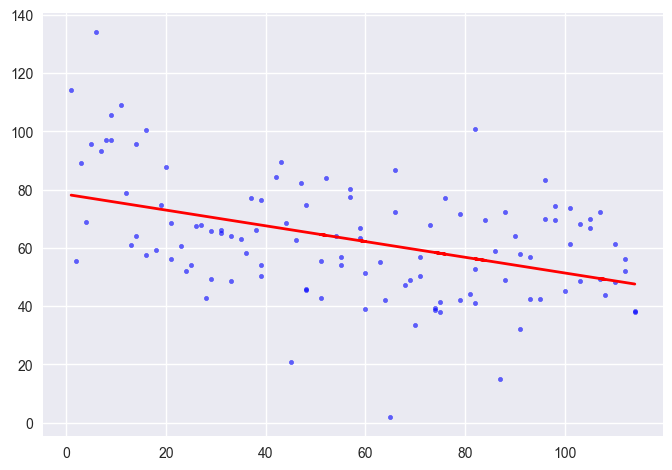

In [127]:
igralci["najbolj_aktiven"] = igralci.total_games / (igralci.age)

def best_fit_line(xs,ys):
    slope = (((mean(xs) * mean(ys)) - mean(xs * ys)) / ((mean(xs) * mean(xs)) - mean(xs * xs)))
    y_intercept = mean(ys) - slope * mean(xs)
    return slope, y_intercept

# omejiti se moramo na 115 top šahistov, saj drugače vrne mean(ys) = inf, to bi lahko popravili, z uporabo stabilnejše metode za reševanje problema najmanjših kvadratov

igralci_copy = igralci[:115]

xs = np.array(igralci_copy["mesto"].to_list(), dtype=np.float64)
ys = np.array(igralci_copy["najbolj_aktiven"].to_list(), dtype=np.float64)

slope, intercept = best_fit_line(xs,ys)

regression_line = [(slope * x) + intercept for x in xs]

print(igralci_copy["mesto"].corr(igralci_copy["najbolj_aktiven"]))

style.use('seaborn')
plt.scatter(xs,ys, label = "DataPoints", alpha=0.6, color = "blue", s = 10)
plt.plot(xs ,regression_line, label = "BestFitLine", color = "red", linewidth = 2)
plt.show()


Korelacijski koeficient je po absolutni vrednosti velik, predznak pa nam pove, da vrednost "aktivnost_igralca" narašča z manjšanjem mesta na lestvici. To potrdi našo domnevo.
Na grafu opazimo, da so točke razmeroma lepo razporejene, seveda pa pride do izjem (sploh pri mlajših/starejših igralcih).

Domneva deluje ob predpostavkah, ki jih v realnem svetu nemoremo kar tako sprejeti. Vseeno pa potrjuje, da brez trdega dela in velikega števila odigranih partij nemoremo kar tako postati vrhunski šahist.